## Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

### Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [76]:
# Load the data file and display the DataFrame:
import pandas as pd
df = pd.read_csv('cleaned_ecommerce_dataset.csv')
print("Length of the data: ", len(df))

# Set display width
pd.set_option('display.width', 1000)

Length of the data:  2685


In [77]:
df_summary = df.copy()

# Convert 'userId', 'item_id', 'user_city' to object data type
df_summary['userId'] = df_summary['userId'].astype('object')
df_summary['item_id'] = df_summary['item_id'].astype('object')
df_summary['user_city'] = df_summary['user_city'].astype('object')

# Summary of numerical data
numerical_columns = ['rating', 'helpfulness', 'item_price']
numerical_summary = df_summary[numerical_columns].describe().round(2)
print("\nSummary of numerical data:\n")
print(numerical_summary)

print ('------------------------------------------------------------------------------------------------------------')

# Summary of categorical data
categorical_columns = ['userId', 'gender', 'review', 'item', 'category', 'item_id', 'user_city']
categorical_summary = df_summary[categorical_columns].describe(include=['O'])
print("\nSummary of categorical data:\n")
print(categorical_summary)


Summary of numerical data:

        rating  helpfulness  item_price
count  2685.00      2685.00     2685.00
mean      3.71         3.91       83.09
std       1.35         0.29       42.23
min       1.00         3.00       12.00
25%       3.00         4.00       49.00
50%       4.00         4.00       73.65
75%       5.00         4.00      129.82
max       5.00         4.00      149.00
------------------------------------------------------------------------------------------------------------

Summary of categorical data:

        userId gender                review                  item category  item_id  user_city
count     2685   2685                  2685                  2685     2685     2685       2685
unique     267      2                  2675                    82        9       82         40
top       6408      M  Being John Malkovich  AOL (America Online)   Movies        0         27
freq        33   1407                     3                    93     1190       93        

### Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict ratings given other columns, please get the correlations between helpfulness/gender/category/review and rating by using the `corr()` method.

  Hints: To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, category and review) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ correlated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

#### 1.1. Brief information about the data

In [78]:
print ('The current DataFrame: ','\n', df.head(5))
print ('---------------------------------------------------')
print (df.info())

The current DataFrame:  
    userId  timestamp                                           review                                item  rating  helpfulness gender               category  item_id  item_price  user_city
0    4081      71900                                Not always McCrap                          McDonald's     4.0          3.0      M  Restaurants & Gourmet       41       30.74          4
1    4081      72000  I dropped the chalupa even before he told me to                           Taco Bell     1.0          4.0      M  Restaurants & Gourmet       74      108.30          4
2    4081      72000                     The Wonderful World of Wendy                             Wendy's     5.0          4.0      M  Restaurants & Gourmet       84       69.00          4
3    4081     100399                             They actually did it  South Park: Bigger, Longer & Uncut     5.0          3.0      M                 Movies       68      143.11          4
4    4081     100399         

#### 1.2. The correlations between helpfulness/gender/category/review and rating

##### Convert categorical variables to numerical

In [79]:
# Convert categorical variables to numerical
ord_enc = OrdinalEncoder()
df[['gender_encode', 'category_encode', 'review_encode']] = ord_enc.fit_transform(df[['gender', 'category', 'review']])

print ('The current DataFrame after encoding: ','\n', df.head(5))

The current DataFrame after encoding:  
    userId  timestamp                                           review                                item  rating  helpfulness gender               category  item_id  item_price  user_city  gender_encode  category_encode  review_encode
0    4081      71900                                Not always McCrap                          McDonald's     4.0          3.0      M  Restaurants & Gourmet       41       30.74          4            1.0              8.0         1618.0
1    4081      72000  I dropped the chalupa even before he told me to                           Taco Bell     1.0          4.0      M  Restaurants & Gourmet       74      108.30          4            1.0              8.0         1125.0
2    4081      72000                     The Wonderful World of Wendy                             Wendy's     5.0          4.0      M  Restaurants & Gourmet       84       69.00          4            1.0              8.0         2185.0
3    4081     1

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userId           2685 non-null   int64  
 1   timestamp        2685 non-null   int64  
 2   review           2685 non-null   object 
 3   item             2685 non-null   object 
 4   rating           2685 non-null   float64
 5   helpfulness      2685 non-null   float64
 6   gender           2685 non-null   object 
 7   category         2685 non-null   object 
 8   item_id          2685 non-null   int64  
 9   item_price       2685 non-null   float64
 10  user_city        2685 non-null   int64  
 11  gender_encode    2685 non-null   float64
 12  category_encode  2685 non-null   float64
 13  review_encode    2685 non-null   float64
dtypes: float64(6), int64(4), object(4)
memory usage: 293.8+ KB


##### Calculate the correlations between variables

In [82]:
# Select the columns: 'rating', 'helpfulness' and encoded variables of 'gender_encode', 'category_encode', 'review_encode'
selected_columns = df[['rating', 'helpfulness', 'gender_encode', 'category_encode', 'review_encode']]

# Calculate correlation matrix
correlation_matrix = selected_columns.corr()
correlation_matrix


,rating,helpfulness,gender_encode,category_encode,review_encode
rating,1.000000,-0.007523,-0.034337,-0.163158,-0.036118
helpfulness,-0.007523,1.000000,0.075947,-0.013408,-0.028259
gender_encode,-0.034337,0.075947,1.000000,0.022549,-0.037884
category_encode,-0.163158,-0.013408,0.022549,1.000000,0.001970
review_encode,-0.036118,-0.028259,-0.037884,0.001970,1.000000


<Axes: >

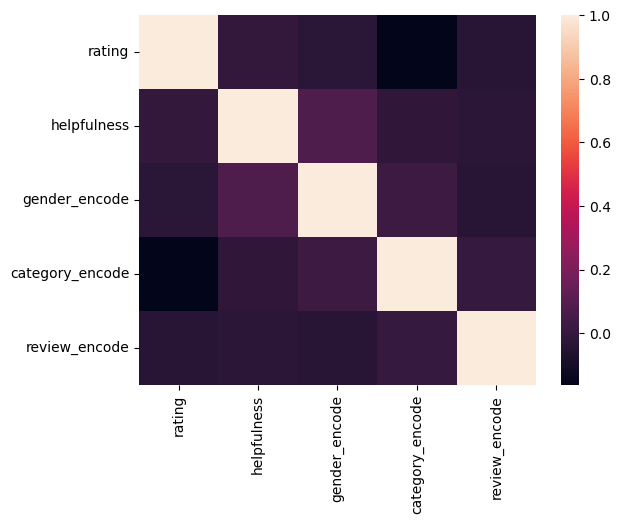

In [83]:
sns.heatmap (correlation_matrix)

#### 1.3. Please provide necessary explanations/analysis on the correlations, and figure out which are the most and least correlated features regarding rating. Try to discuss how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

##### Based on the correlation coefficients, we can identify the most and least correlated features with respect to "rating":

1. Least correlated features with 'rating':

    - "helpfulness" has a correlation of -0.007523 with rating, which is the lowest value (closest to 0) among the given features.
    
    - "gender_encode" has a correlation of -0.034337 with rating, which is the second-lowest.

2. Most correlated features with 'rating':

    - "category_encode" has a correlation of -0.163158 with rating, which is the highest absolute value.

    - "review_encode" has a correlation of -0.036118 with rating, which is the second-highest in absolute value.

3. Regarding the impact of these correlations on the final prediction results when training a regression model for rating prediction:

    - Features with higher coefficients of correlation (in absolute value) tend to have a stronger relationship with the target variable "rating", while those closer to 0 may have weaker impacts on our "rating" at all.

    - For example, variables such as "category_encode" and "review_encode" are likely to have more significant influence on the prediction of 'rating', even in negative direction. As for "helpfulness" and "gender_encode", however, their effects on our predictions might be less clear.
    
    

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [93]:
# Split the data into training and testing sets
def split_data(df, target_column, test_size, random_state=150):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Case 1: Training data contains 10% of the entire data
X_train_1, X_test_1, y_train_1, y_test_1 = split_data(df, 'rating', test_size=0.9,random_state=150)

# Case 2: Training data contains 90% of the entire data
X_train_2, X_test_2, y_train_2, y_test_2 = split_data(df, 'rating', test_size=0.1,random_state=150)

# The shape of the training and testing sets
print("Case 1:")
print("Training set shape:", X_train_1.shape, y_train_1.shape)
print("Testing set shape:", X_test_1.shape, y_test_1.shape)

print("\nCase 2:")
print("Training set shape:", X_train_2.shape, y_train_2.shape)
print("Testing set shape:", X_test_2.shape, y_test_2.shape)


Case 1:
Training set shape: (268, 13) (268,)
Testing set shape: (2417, 13) (2417,)

Case 2:
Training set shape: (2416, 13) (2416,)
Testing set shape: (269, 13) (269,)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features from helpfulness/gender/category/review regarding rating, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of training/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

* Regarding ***'rating'***:
    - <font color="orange">Two most correlated variables: ***'category (encoded)'*** and ***'review (encoded)*** </font> 
    - <font color="orange">Two least correlated variables: ***'helpfulness'*** and ***'gender (encoded)*** </font> 

In [96]:
def prepare_data(df, features, target_column, test_size, random_state=150):
    X = df[features]
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Define the most and least correlated features
most_correlated_features = ['category_encode', 'review_encode']
least_correlated_features = ['helpfulness', 'gender_encode']

# Case 1: Training data contains 10% of the entire data
X_train_1a, X_test_1a, y_train_1a, y_test_1a = prepare_data(df, most_correlated_features, 'rating', test_size=0.9)
X_train_1b, X_test_1b, y_train_1b, y_test_1b = prepare_data(df, least_correlated_features, 'rating', test_size=0.9)

# Case 2: Training data contains 90% of the entire data
X_train_2c, X_test_2c, y_train_2c, y_test_2c = prepare_data(df, most_correlated_features, 'rating', test_size=0.1)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = prepare_data(df, least_correlated_features, 'rating', test_size=0.1)

# Set up the models
model_1a = linear_model.LinearRegression()
model_1b = linear_model.LinearRegression()
model_2c = linear_model.LinearRegression()
model_2d = linear_model.LinearRegression()

# Train the models
model_1a.fit(X_train_1a, y_train_1a)
model_1b.fit(X_train_1b, y_train_1b)
model_2c.fit(X_train_2c, y_train_2c)
model_2d.fit(X_train_2d, y_train_2d)

LinearRegression()

### Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [97]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions) # Using mean_squared_error function
    rmse = np.sqrt(mse)
    return mse, rmse

# Evaluate the models
mse_1a, rmse_1a = evaluate_model(model_1a, X_test_1a, y_test_1a)
mse_1b, rmse_1b = evaluate_model(model_1b, X_test_1b, y_test_1b)
mse_2c, rmse_2c = evaluate_model(model_2c, X_test_2c, y_test_2c)
mse_2d, rmse_2d = evaluate_model(model_2d, X_test_2d, y_test_2d)

# Print the evaluation metrics for each model
print("Model 1a: MSE =", mse_1a, "RMSE =", rmse_1a)
print("Model 1b: MSE =", mse_1b, "RMSE =", rmse_1b)
print("Model 2c: MSE =", mse_2c, "RMSE =", rmse_2c)
print("Model 2d: MSE =", mse_2d, "RMSE =", rmse_2d)


Model 1a: MSE = 1.7846870468004477 RMSE = 1.3359217966634302
Model 1b: MSE = 1.8382768810741097 RMSE = 1.3558306977916195
Model 2c: MSE = 1.6109828009740266 RMSE = 1.269244972798406
Model 2d: MSE = 1.6432233129465736 RMSE = 1.2818827219939326


### Visualize, Compare and Analyze the Results
* Visualize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

#### Visualization of the results

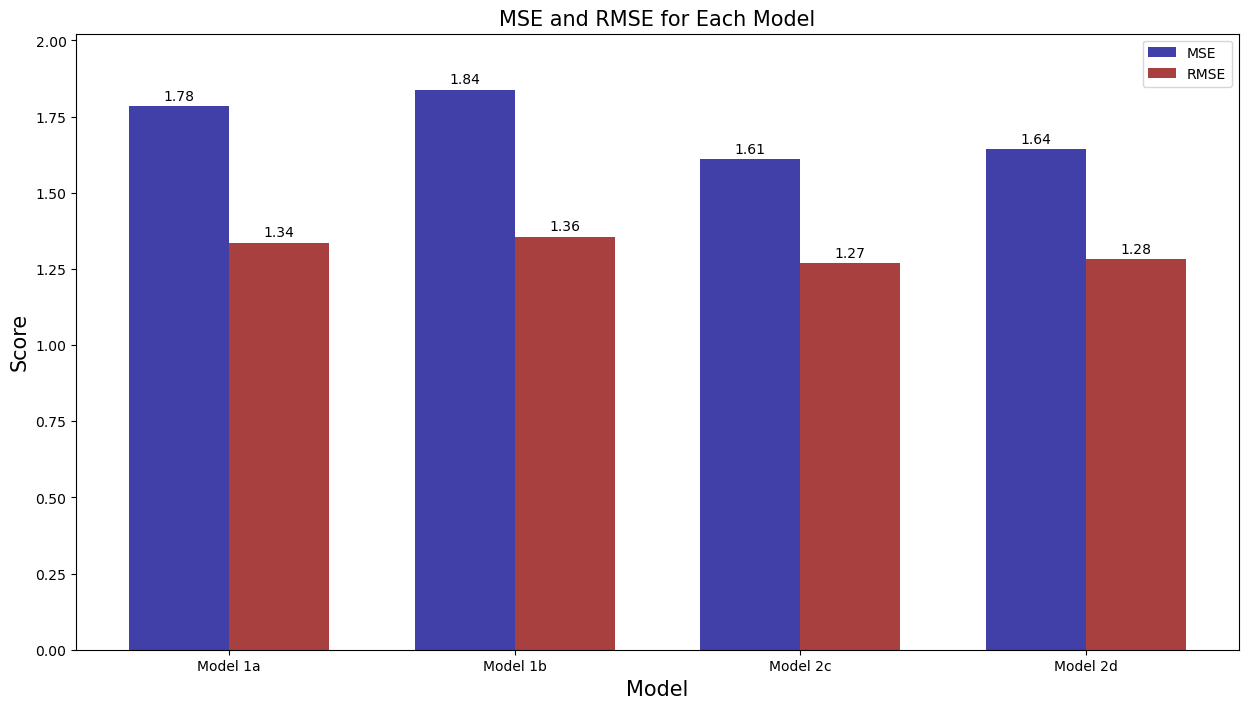

In [98]:
# Define the models and their MSE and RMSE results
models = ['Model 1a', 'Model 1b', 'Model 2c', 'Model 2d']
mse_results = [mse_1a, mse_1b, mse_2c, mse_2d]
rmse_results = [rmse_1a, rmse_1b, rmse_2c, rmse_2d]

# Define the index for the x-coordinates of the bars in the bar plot and the width
index = np.arange(len(models))
bar_width = 0.35

# Create a bar plot for MSE and RMSE of each model
plt.figure(figsize=(15, 8))
bars1 = plt.bar(index, mse_results, 
                bar_width, color='darkblue', alpha=0.75, label='MSE')
bars2 = plt.bar(index + bar_width, rmse_results, 
                bar_width, color='darkred', alpha=0.75, label='RMSE')

# Add data labels above the bars
for bars in [bars1, bars2]:
    for bar in bars:
        y_value = bar.get_height()
        plt.text(bar.get_x() + (bar.get_width()/2), 
                 y_value + 0.01, round(y_value, 2), 
                 horizontalalignment='center', verticalalignment='bottom')

# Set the x-axis & y-axis labels and the title
plt.xlabel('Model', size = 15)
plt.ylabel('Score', size =15)
plt.title('MSE and RMSE for Each Model', size = 15)
plt.xticks(index + bar_width / 2, models)  # Position the x-axis labels in the center of the bars groups
plt.ylim(0, max(max(mse_results), max(rmse_results)) * 1.1) # Adjust the y-axis limits to make sure the data labels are not cut off

# Add a legend and show the plot
plt.legend()
plt.show()


#### Analysis of the results

##### 1. The impacts of the data size
- By comparing models trained with the same features (either the two most correlated or the two least correlated), we observe that the models trained with more training data (90% of the entire data, Case 2) generally perform better than the models trained with a smaller training dataset (10% of the entire data, Case 1).

- Specifically, Model 2c (Case 2, most correlated features) has lower MSE (1.61) and RMSE (1.27) compared to Model 1a (Case 1, most correlated features) with MSE of 1.78 and RMSE of 1.34.

- In comparison to Model 1b having MSE of 1.84 and RMSE of 1.36 (Case 1, least correlated features), Model 2d (Case 2, least correlated features) is considered better due to its lower MSE (1.64) and RMSE (1.28). 

##### 2. The impacts of feature selection
- For both Case 1 (training data of 10%) and Case 2 (training data of 90%), the models trained with the two most correlated features consistently outperform the models trained with the two least correlated features.

- In Case 1, lower values of MSE (1.78) and RMSE (1.34) are witnessed in Model 1a (most correlated features) compared to those of MSE (1.84) and RMSE (1.36) in Model 1b (least correlated features) 

- In Case 2, Model 2c (most correlated features) has lower MSE (1.61) and RMSE (1.27) in comparison to Model 2d (least correlated features) with MSE of 1.64 and RMSE of 1.28.

##### 3. Overall conclusion:

- The model with the best overall performance, in terms of having the lowest MSE (1.61) and RMSE (1.27), is <font color="orange"> __Model 2c__ </font> . This model is trained with the two most correlated features (___category_encode___ & ___review_encode___) and the larger training dataset (90% of the entire data, Case 2).

- Regarding the highest values of MSE and RMSE, i.e. the worst overall performance, it is <font color="orange"> __Model 1b__ </font> with MSE (1.84) and RMSE (1.36). This model is trained using the smaller training data (only 10% of the entire data, Case 1) along with the two least correlated features (___helpfulness____ & ___gender_encode___).

- The models' results clearly demonstrate the fundamental principles of machine learning. When models are trained with features that have a stronger correlation with the target variable, they tend to produce better results, which can affect their ability to make accurate predictions. 

- The importance of the size of the training/ testing data on the performance model is also highlighted via the models' outputs. The more data is employed to train the model, the better it can learn from the attributes of the current data, thereby enhancing its capacity to generalize better to unseen data.

### Data Science Ethics
*Please read the following examples [Click here to read the example_1.](https://www.vox.com/covid-19-coronavirus-us-response-trump/2020/5/18/21262265/georgia-covid-19-cases-declining-reopening) [Click here to read the example_2.](https://viborc.com/ethics-and-ethical-data-visualization-a-complete-guide/)

*Then view the picture ![My Image](figure_portfolio2.png "This is my image")
Please compose an analysis of 100-200 words that evaluates potential ethical concerns associated with the infographic, detailing the reasons behind these issues.


#### Data Science Ethics on The Inforgraphic of 2008 Summer Olympic Medals

- The given infographic provides details on two tables of the medal counts from the 2008 Summer Olympics, arranged by total medals (Table 1) and gold medals (Table 2). Despite its straightforward nature in the comparison of the countries’ performance in the sports competition, the infographic might raise several potential ethical concerns related to data visualization practices.

- Firstly, the two tables may cause misinterpretation due to their sorting criteria. While Table 1 ranks countries by the total number of medals won, the number of gold medals is chosen as the criteria to rank participating countries. This way of sorting could lead to confusion about which country really won the Olympics, as audiences might not easily notice the difference between two tables in terms of sorting methods. Moreover, placing one table above the other could “unintentionally” create a perceived hierarchy between them, implying that the information in Table 1 holds more significance than that in Table 2. People might find it difficult to understand which country performed better and could assume the tables are contradictory or the arrangement of data is misorganized.

- A further ethical concern is the possibility of presentation bias in the data. The potential bias in favour of the United States is indicated by the data arrangement and design, as evidenced by its top-ranked position in Table 1 and its substantial total medal count. In terms of gold medals, China exhibited superior performance compared to the United States; however, this table holds the second position, as previously stated. This could be seen as downplaying the significance of China's accomplishments at the Olympics.

- Lastly, compared to Table 1, the size of Table 2 is unbalanced with the data, causing the inside content (title, nations' names and flags, data label, etc.) to be smaller and less prominent. This inconsistency in the representation might give less visual importance to the countries in Table 2.

